# Augmentation Gallery

This example showcases different augmentations possible with DALI.

`DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

In [1]:
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import numpy as np
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
import math
import os.path

test_data_root = os.environ['DALI_EXTRA_PATH']
db_folder = os.path.join(test_data_root, 'db', 'lmdb')

augmentations = {}

# input is sampled randomly for output pixel's neighbourhood
augmentations["erase"] = \
    lambda images: fn.erase(images, anchor=[0.3, 0.2], shape=[0.5, 0.6],
                            normalized_anchor=True, normalized_shape=True, axis_names='HW')

augmentations["slice"] = \
    lambda images: fn.slice(images, rel_start=[0.3, 0.2], rel_shape=[0.5, 0.6], axis_names='HW')

# transforms sampling coordinates to produce wavy patterns
augmentations["water"] = \
    lambda images: fn.water(images)

# applies fisheye distortion
augmentations["sphere"] = \
    lambda images: fn.sphere(images)

# rotates the image, enlarging the canvas
augmentations["rotate"] = \
    lambda images: fn.rotate(images, angle=30, interp_type=types.INTERP_LINEAR, fill_value=0)

# applies affine transform
augmentations["warp_affine"] = \
    lambda images: fn.warp_affine(images, matrix=[1.0, 0.8, 0.0, 0.0, 1.2, 0.0],
                                  interp_type=types.INTERP_LINEAR) 

# manipulates brightness and contrast of the image
augmentations["brightness_contrast"] = \
    lambda images: fn.brightness_contrast(images, brightness=0.5, contrast=1.5)

# Generate JPEG compression artifacts
augmentations["jpeg compression distortion"] = \
    lambda images: fn.jpeg_compression_distortion(images, quality=5)

# twists colors of the image
augmentations["hsv"] = \
    lambda images: fn.hsv(images, hue=45., saturation=0.2)

# places the image on a larger canvas
augmentations["paste"] = \
    lambda images: fn.paste(images, ratio=2., fill_value=(55, 155, 155), paste_x=.1, paste_y=.7)

# param flips the image 
augmentations["horizontal flip"] = \
    lambda images: fn.flip(images, vertical=0, horizontal=1)


@pipeline_def()
def augmentation_gallery_pipe(path):
    encoded, labels = fn.readers.caffe(path = path, random_shuffle = True)
    images = fn.decoders.image(encoded, device = "mixed", output_type = types.RGB)
    return tuple([labels, images] + [aug(images) for aug in augmentations.values()])



In [2]:
pipe = augmentation_gallery_pipe(path=db_folder, batch_size=32, num_threads=2, device_id=0, seed=10)
pipe.build()

In [3]:
pipe_out = pipe.run()

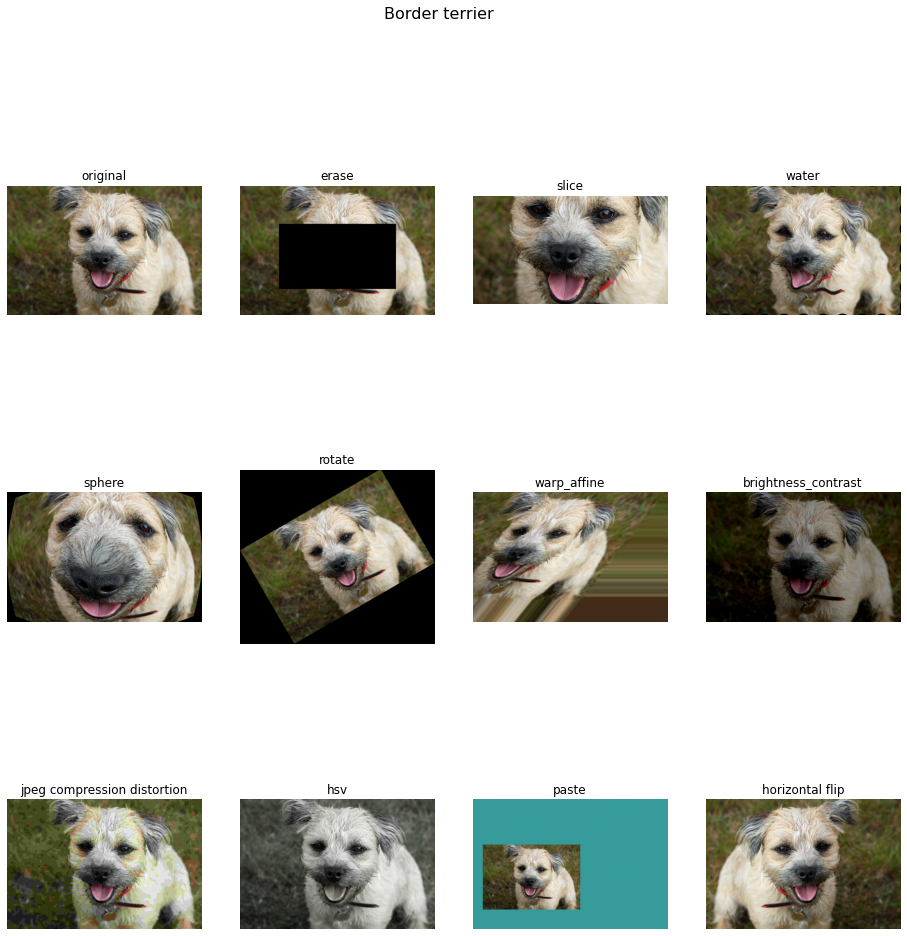

In [4]:
n = 5
from synsets import imagenet_synsets
import matplotlib.gridspec as gridspec
len_outputs = len(pipe_out) - 1
augmentations = ["original"] + list(augmentations.keys())
fig = plt.figure(figsize = (16,16))
plt.suptitle(imagenet_synsets[pipe_out[0].at(n)[0]], fontsize=16)
columns = 4
rows = int(math.ceil(len_outputs / columns))
gs = gridspec.GridSpec(rows, columns)
for i in range(len_outputs):
    plt.subplot(gs[i])
    plt.axis("off")
    plt.title(augmentations[i])
    pipe_out_cpu = pipe_out[1 + i].as_cpu()
    img_chw = pipe_out_cpu.at(n)
    plt.imshow((img_chw)/255.0)